Mask R-CNN Image Segmentation Demo

In [ ]:
#Use a free Cloud TPU

#Download Mask R-CNN model
!git clone https://github.com/tensorflow/tpu/

Cloning into 'tpu'...
remote: Enumerating objects: 9413, done.
remote: Total 9413 (delta 0), reused 0 (delta 0), pack-reused 9413
Receiving objects: 100% (9413/9413), 24.11 MiB | 26.69 MiB/s, done.
Resolving deltas: 100% (6775/6775), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#library 
from IPython import display
from PIL import Image
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

TensorFlow 1.x selected.


In [ ]:
#id of object classified in pretrained model
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

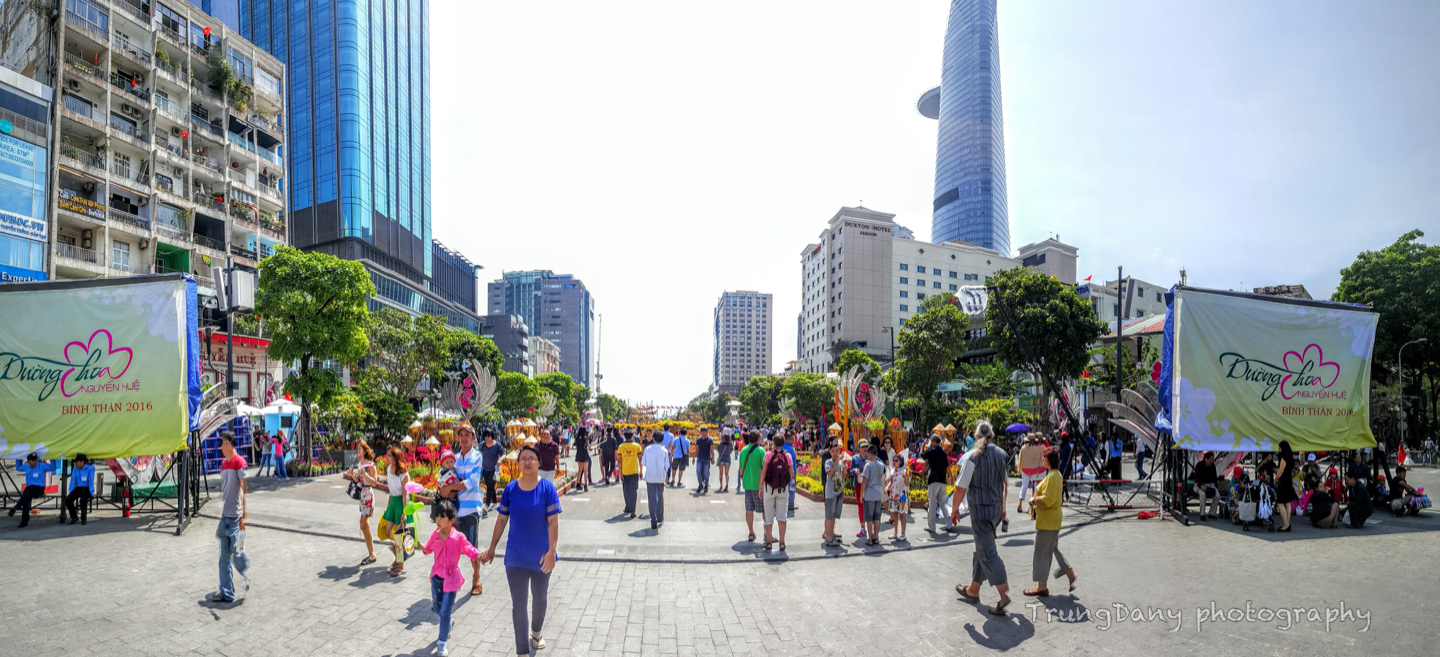

In [ ]:
#load and display image
image_path = '/content/Pho_Di_Bo_Nguyen_hue,_Ngay_tet_2016,Bến_Thành,_Quận_1,_Hồ_Chí_Minh,_Việt_Nam_-_panoramio.jpg'

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])

image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

In [ ]:
#connect to TPU and use
import os
import pprint

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
print('TPU devices:')
pprint.pprint(session.list_devices())

TPU address is grpc://10.13.255.146:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 12285695743415442625),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3227711329259498167),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6576185030916922824),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 13689259729686806363),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 3567056687904982753),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 11986165372489778078),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 8375770318419775858),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 13446071997497811245),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 14454933227

In [ ]:
#download COCO pretrained model 

saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' 
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

INFO:tensorflow:Restoring parameters from gs://cloud-tpu-checkpoints/mask-rcnn/1555659850/variables/variables


In [ ]:
#run the inference and process the predictions

num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

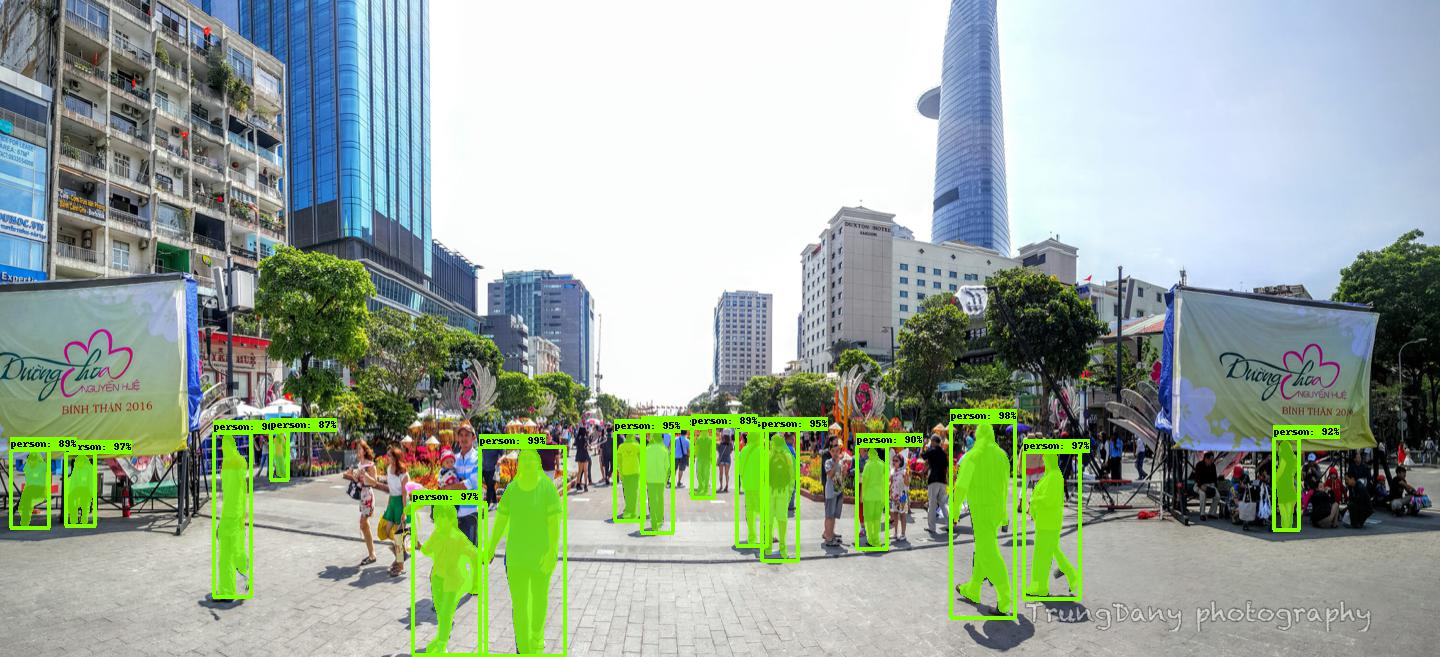

In [ ]:
max_boxes_to_draw =    15#@param {type:"integer"}
min_score_thresh = 0.72    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))

generative_inpainting

In [ ]:
pip install git+https://github.com/JiahuiYu/neuralgym

  Cloning https://github.com/JiahuiYu/neuralgym to /tmp/pip-req-build-zh6kspev
  Running command git clone -q https://github.com/JiahuiYu/neuralgym /tmp/pip-req-build-zh6kspev
  Created wheel for neuralgym: filename=neuralgym-0.0.1-cp36-none-any.whl size=40426 sha256=e7565660b3fdde852a1644a62854b66d179847a45c732345fbce0d2176abdc01
  Stored in directory: /tmp/pip-ephem-wheel-cache-tk_a79d2/wheels/bc/dd/bc/fbaacf774dfc69223a01b3e037b8539f24318193a37221bb3b
Successfully built neuralgym


In [67]:
#clone project generative_inpainting from github
!git clone https://github.com/JiahuiYu/generative_inpainting
!cd /content/generative_inpainting
model_dir = '/content/generative_inpainting'

fatal: destination path 'generative_inpainting' already exists and is not an empty directory.


In [ ]:
#unzip pretrained-model
import zipfile
!unzip "/content/release_places2_256_deepfill_v2-20200806T133057Z-001.zip" -d "/content/tpu/model_logs"

Archive:  /content/release_places2_256_deepfill_v2-20200806T133057Z-001.zip
  inflating: /content/tpu/model_logs/release_places2_256_deepfill_v2/snap-0.index  
  inflating: /content/tpu/model_logs/release_places2_256_deepfill_v2/checkpoint  
  inflating: /content/tpu/model_logs/release_places2_256_deepfill_v2/snap-0.meta  
  inflating: /content/tpu/model_logs/release_places2_256_deepfill_v2/snap-0.data-00000-of-00001  


In [ ]:
#Load pretrained model
!python $model_dir/test.py --image /content/generative_inpainting/examples/places2/case1_input.png\
 --mask /content/generative_inpainting/examples/places2/case1_mask.png\
  --output /content/generative_inpainting/examples/places2/case1_output.png\
   --checkpoint /content/tpu/model_logs/release_places2_256_deepfill_v2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




---------------------------------- APP CONFIG ----------------------------------
num_gpus_per_job: 1
num_cpus_per_job: 4
num_hosts_per_job: 1
memory_per_job: 32
gpu_type: nvidia-tesla-p100
name: places2_gated_conv_v100
model_restore: 
dataset: celebahq
random_crop: False
val: False
log_dir: logs/full_model_celeba_hq_256
gan: sngan
gan_loss_alpha: 1
gan_with_mask: True
discounted_mask: True
random_seed: False
padding: SAME
train_spe: 4000
max_iters: 100000000
viz_max_out: 10
val_psteps: 2000
data_flist: 
  celebahq: ['data/celeba_hq/train_shuffled.flist', 'data/celeba_hq/validation_static_view.flist']
  celeba: ['data/celeba/t